In [1]:
import sys
import math
from math import *
import Geant4
from Geant4 import cm, mm, MeV, GeV, TeV, G4ThreeVector
import ROOT
import logging
logging.basicConfig(level=logging.INFO, stream = sys.stderr)
logger = logging.getLogger("geant4")


**************************************************************
 Geant4 version Name: geant4-10-07-patch-03    (19-November-2021)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

Visualization Manager instantiating with verbosity "warnings (3)"...
Welcome to JupyROOT 6.18/04


In [2]:
Geant4.G4NistManager.Instance().ListMaterials("all")

###   Simple Materials from the NIST Data Base      ###
 Z   Name   density(g/cm^3)  I(eV)                     
 1   G4_H    8.3748e-05       19.2
 2  G4_He   0.000166322       41.8
 3  G4_Li         0.534         40
 4  G4_Be         1.848       63.7
 5   G4_B          2.37         76
 6   G4_C             2         81
 7   G4_N     0.0011652         82
 8   G4_O    0.00133151         95
 9   G4_F    0.00158029        115
10  G4_Ne   0.000838505        137
11  G4_Na         0.971        149
12  G4_Mg          1.74        156
13  G4_Al         2.699        166
14  G4_Si          2.33        173
15   G4_P           2.2        173
16   G4_S             2        180
17  G4_Cl    0.00299473        174
18  G4_Ar    0.00166201        188
19   G4_K         0.862        190
20  G4_Ca          1.55        191
21  G4_Sc         2.989        216
22  G4_Ti          4.54        233
23   G4_V          6.11        245
24  G4_Cr          7.18        257
25  G4_Mn          7.44        272
26  G4_Fe    

In [3]:
class CreateBox:
    def __init__(self, name, materialName, parent, x, y, z, sx, sy, sz):
        self.name = name
        self.solid = Geant4.G4Box(self.name.lower()+"box", 0.5*sx, 0.5*sy, 0.5*sz)
        m = Geant4.G4NistManager.Instance().FindOrBuildMaterial(materialName)
        self.logical = Geant4.G4LogicalVolume(self.solid, m, self.name, None, None, None, True)
        r0 = G4ThreeVector(x, y, z)
        self.physical_placement = Geant4.G4PVPlacement(None, r0, self.logical, self.name, parent, False, 0)

In [4]:
#В направлении по оси z испускаются фотоны, энергия 6 МэВ, угловой разброс 0.001 градус,
#в 5 см ортогонально пучку расположен куб из чистого германия (детектор), размер ребра 5 см, 
#за ним вплотную – кубический свинцовый поглотитель; размер ребра 20 см
class DetectorConstructor(Geant4.G4VUserDetectorConstruction):
    def __init__(self):
        super().__init__()
        self.world = CreateBox("World", "G4_Galactic", None, 0, 0, 0, 200*cm, 200*cm, 500*cm)
        self.germany_detector = CreateBox("Detector", "G4_Ge", self.world.logical, 0, 0, (5.0+2.5)*cm, 5.0*cm, 5.0*cm, 5.0*cm)
        self.absorber = CreateBox("Absorber", "G4_Pb", self.world.logical, 0, 0, (5.0+5.0+10.0)*cm, 20.0*cm, 20.0*cm, 20.0*cm)

    def Construct(self):
        logger.info("construct detector")
        return self.world.physical_placement

In [5]:
class PrimaryGenerator(Geant4.G4VUserPrimaryGeneratorAction):
    def __init__(self):
        super().__init__()

        self.energy         = 6.0*MeV
        self.energySpread   = 0.0*MeV

        self.z          =  0.0*mm
        self.zSpread    = 0.0*mm

        self.theta0 = 0.
        self.theta1 = 2. / 180. * math.pi
        
        self.gun   = Geant4.G4ParticleGun()

        # set particle type
        self.particle = Geant4.G4ParticleTable.GetParticleTable().FindParticle("gamma")
        assert self.particle is not None
        self.gun.SetParticleDefinition(self.particle)

        pass

    def GeneratePrimaries(self, anEvent):
        p = Geant4.G4ThreeVector(0.0, 0.0, self.z)
        self.gun.SetParticlePosition(p)
        self.gun.SetParticleEnergy(self.energy)

        sigmax = math.atan(self.theta1)
        sigmay = math.atan(self.theta1)
        xi = ROOT.gRandom.Uniform(0.0, 1.0)
        r1 = math.sqrt( -2.0 * math.log(xi))
        phi = ROOT.gRandom.Uniform(0.0, 2.0 * math.pi)
        x = r1 * math.cos(phi) * sigmax
        y = r1 * math.sin(phi) * sigmay
        r = math.sqrt(x ** 2 + y ** 2 + 1.0)
        direction = Geant4.G4ThreeVector(x/r, y/r, 1.0/r)
        
        self.gun.SetParticleMomentumDirection(direction)

        self.gun.GeneratePrimaryVertex(anEvent)
        logger.debug("generate primary event")


In [6]:
class EventAction(Geant4.G4UserEventAction):
    def __init__(self, germany_sd, absorber_sd, detector_hist, absorber_hist, energy_rate_hist):
        super().__init__()
        self.germany_sd = germany_sd
        self.absorber_sd = absorber_sd
        self.detector_hist = detector_hist
        self.absorber_hist = absorber_hist
        self.energy_rate_hist = energy_rate_hist
        
    def BeginOfEventAction(self, event):
        pass
                        
    def EndOfEventAction(self, event):
        self.detector_hist.Fill(self.germany_sd.energy)
        self.absorber_hist.Fill(self.absorber_sd.energy)
        accumulated_energy = self.absorber_sd.energy + self.germany_sd.energy
        if accumulated_energy >= 1e-6:
            self.energy_rate_hist.Fill(self.germany_sd.energy / accumulated_energy)
    
    def ResetHists(self):
        self.detector_hist.Reset()
        self.absorber_hist.Reset()
        self.energy_rate_hist.Reset()

In [7]:
class SensitiveDetector(Geant4.G4VSensitiveDetector):
    def __init__(self, name):
        super().__init__(name)
        self.energy = 0.0

    def ProcessHits (self, step, rohistory):
        deposit = step.GetTotalEnergyDeposit() / MeV
        self.energy += deposit
        return True

    def Initialize (self, coll):
        self.energy = 0.0

    def EndOfEvent (self, coll):
        pass

In [8]:
manager = Geant4.gRunManager

In [9]:
PhysicsList = Geant4.FTFP_BERT
physics = PhysicsList()
manager.SetUserInitialization(physics)

<<< Geant4 Physics List simulation engine: FTFP_BERT



In [10]:
constructor = DetectorConstructor()
manager.SetUserInitialization(constructor)

# ну оочень шумные эти физикслисты...
Geant4.gApplyUICommand("/process/had/verbose 0")
Geant4.gApplyUICommand("/process/em/verbose 0")

generator = PrimaryGenerator()
manager.SetUserAction(generator)

In [11]:
germany_sd = SensitiveDetector("/detector/GerDet")
absorber_sd = SensitiveDetector("/absorber/PbAb")

constructor.germany_detector.logical.SetSensitiveDetector(germany_sd)
constructor.absorber.logical.SetSensitiveDetector(absorber_sd)

In [12]:
sdmanager = Geant4.G4SDManager.GetSDMpointer()
sdmanager.AddNewDetector(germany_sd)
sdmanager.AddNewDetector(absorber_sd)
sdmanager.ListTree()

/
/detector/
/detector/GerDet   *** Active 
/absorber/
/absorber/PbAb   *** Active 


In [13]:
detector_energy = ROOT.TH1F("detector_energy", "detector_energy",100, -0.1, 6.3)
absorber_energy = ROOT.TH1F("absorber_energy", "absorber_energy", 100, -0.1, 6.3)
energy_rate = ROOT.TH1F("energy rate", "energy rate", 100, -0.1, 1.)

In [14]:
eventcallback = EventAction(germany_sd, absorber_sd, detector_energy, absorber_energy, energy_rate)
manager.SetUserAction(eventcallback)
eventcallback.ResetHists()

In [15]:
manager.Initialize()

INFO:geant4:construct detector



 hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval 
 for pions :   3 to 6 GeV
 for kaons :   3 to 6 GeV
 for proton :  3 to 6 GeV
 for neutron : 3 to 6 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0


In [16]:
Geant4.gApplyUICommand("/vis/x3dfile/viewHalfAngle 20")
Geant4.gApplyUICommand("/vis/open X3DFILE")
Geant4.gApplyUICommand("/vis/viewer/flush")
Geant4.gApplyUICommand("/vis/viewer/set/autoRefresh false")
Geant4.gApplyUICommand("/vis/viewer/refresh")
Geant4.gApplyUICommand("/vis/scene/create")
Geant4.gApplyUICommand("/vis/scene/add/volume")
Geant4.gApplyUICommand("/vis/viewer/set/globalLineWidthScale 5")
#Geant4.gApplyUICommand("/vis/geometry/set/colour Calorimeter red")
Geant4.gApplyUICommand("/vis/drawVolume")
#Geant4.gApplyUICommand("/vis/viewer/flush")
Geant4.gApplyUICommand("/vis/viewer/set/viewpointVector -1 -1 0")
Geant4.gApplyUICommand("/vis/viewer/set/lightsVector -1 -1 0")
Geant4.gApplyUICommand("/vis/modeling/trajectories/create/drawByParticleID")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set gamma white")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set proton blue")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set e- yellow")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set e+ green")
Geant4.gApplyUICommand("/vis/sceneHandler/attach")

Geant4.gApplyUICommand("/vis/set/lineWidth 1")
Geant4.gApplyUICommand("/vis/scene/add/axes 0")

Geant4.gApplyUICommand("/vis/viewer/zoom 1.")
Geant4.gApplyUICommand("/tracking/storeTrajectory 1")
Geant4.gApplyUICommand("/vis/set/lineWidth 2")
Geant4.gApplyUICommand("/vis/scene/add/trajectories")
Geant4.gApplyUICommand("/vis/scene/add/hits")
Geant4.gApplyUICommand("/vis/scene/add/trajectories smooth")
#Geant4.gApplyUICommand("/vis/scene/endOfEventAction accumulate")
Geant4.gApplyUICommand("/vis/scene/add/scale")

#Geant4.gApplyUICommand("/vis/scene/add/eventID 0")
#Geant4.gApplyUICommand("/vis/scene/add/date")
Geant4.gApplyUICommand("/vis/viewer/set/autoRefresh true")
Geant4.gApplyUICommand("/vis/enable false")

Geant4.gApplyUICommand("/vis/viewer/set/style wireframe")
Geant4.gApplyUICommand("/vis/viewer/set/viewpointThetaPhi 60 10")
Geant4.gApplyUICommand("/vis/geometry/set/colour Calorimeter 0 1 0 0 0")
Geant4.gApplyUICommand("/vis/geometry/set/colour World 0 0 0 1 0.6")
#Geant4.gApplyUICommand("/vis/geometry/set/forceWireframe World 0 0")
#Geant4.gApplyUICommand("/vis/geometry/set/colour World 0 0 0")

/tracking/storeTrajectory 1
/tracking/storeTrajectory 2


0

In [17]:
from glob import glob
import os
for fdel in glob("g4*.html"):
    os.unlink(fdel)
#logger.setLevel(logging.DEBUG)
Geant4.gApplyUICommand("/vis/enable true")
manager.BeamOn(3)
Geant4.gApplyUICommand("/vis/enable false")
logger.setLevel(logging.INFO)

print(glob("g4*.html"))

['g4_00.html', 'g4_01.html', 'g4_02.html']


In [18]:
import IPython
with open("g4_00.html", "r") as x3dfile:
        data = x3dfile.read()
IPython.display.HTML(data)

In [19]:
with open("g4_01.html", "r") as x3dfile:
        data = x3dfile.read()
IPython.display.HTML(data)

In [20]:
with open("g4_02.html", "r") as x3dfile:
        data = x3dfile.read()
IPython.display.HTML(data)

In [21]:
Geant4.gApplyUICommand("/vis/enable false")
# manager.BeamOn(100)

0

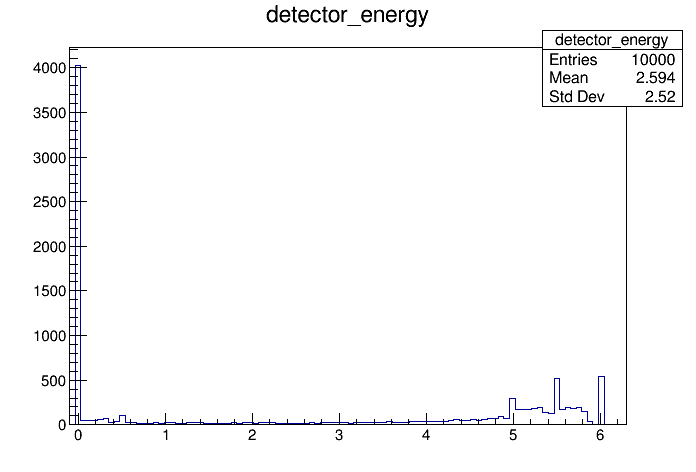

In [22]:
canvas = ROOT.TCanvas("canvas")
canvas.cd()

eventcallback.ResetHists()
manager.BeamOn(10000)

detector_energy.Draw()
canvas.Draw()

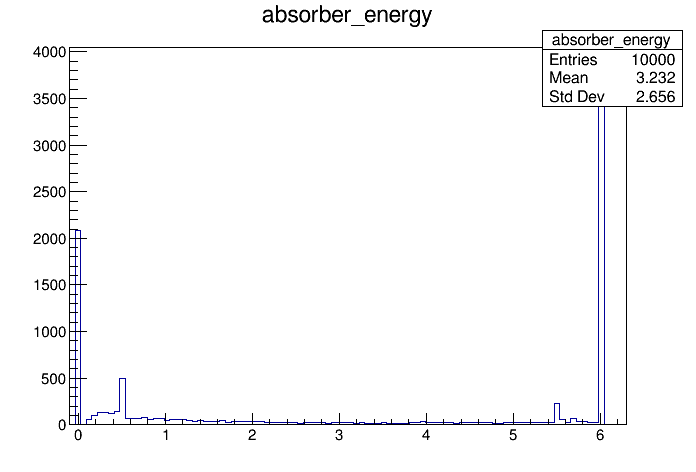

In [23]:
absorber_energy.Draw()
canvas.Draw()

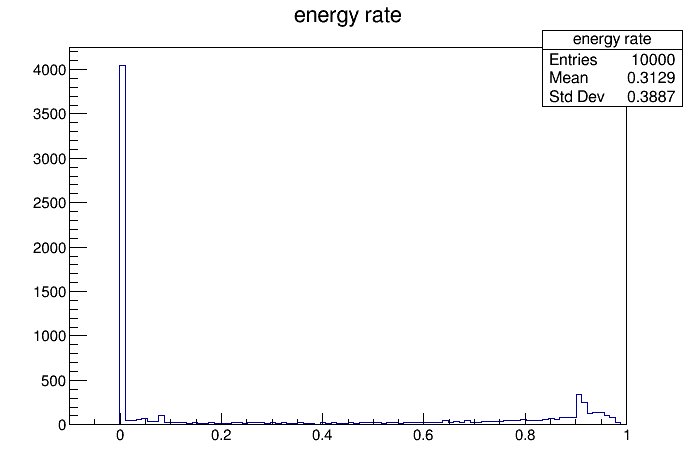

In [24]:
energy_rate.Draw()
canvas.Draw()